
# Statistical Testing for Deep RL

In [1]:
import sys
import os
import re
import glob
import time
import json
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, rankdata
import matplotlib
import matplotlib.pyplot as plt

# ============================================================================
# Statistical tests from rl_stats (https://github.com/flowersteam/rl_stats)
# Re-implemented here to avoid bootstrapped dependency
# ============================================================================

tests_list = ['t-test', "Welch t-test", 'Mann-Whitney', 'Ranked t-test', 'bootstrap', 'permutation']


def run_permutation_test(all_data, n1, n2):
    """Helper for permutation test."""
    np.random.shuffle(all_data)
    data_a = all_data[:n1]
    data_b = all_data[-n2:]
    return data_a.mean() - data_b.mean()


def compute_central_tendency_and_error(id_central, id_error, sample):
    """
    Compute central tendency and error bands (from rl_stats).
    
    Args:
        id_central: 'mean' or 'median'
        id_error: 'std', 'sem', or int (percentile, e.g., 80)
        sample: array of shape (n_steps, n_seeds)
    
    Returns:
        central, low, high arrays
    """
    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == 'mean':
        central = np.nanmean(sample, axis=1)
    elif id_central == 'median':
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == 'std':
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == 'sem':
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[1])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[1])
    else:
        raise NotImplementedError

    return central, low, high


def run_test(test_id, data1, data2, alpha=0.05):
    """
    Run statistical test comparing data1 and data2 (from rl_stats).
    
    Args:
        test_id: test name from tests_list
        data1, data2: sample arrays
        alpha: significance level
    
    Returns:
        bool: True if H0 is rejected (significant difference)
    """
    import warnings
    
    data1 = np.asarray(data1).squeeze()
    data2 = np.asarray(data2).squeeze()
    n1 = data1.size
    n2 = data2.size

    if test_id == 'bootstrap':
        # Simple bootstrap CI test (without bootstrapped package)
        n_boot = 1000
        diffs = []
        for _ in range(n_boot):
            s1 = np.random.choice(data1, size=n1, replace=True)
            s2 = np.random.choice(data2, size=n2, replace=True)
            diffs.append(np.mean(s1) - np.mean(s2))
        diffs = np.array(diffs)
        lo = np.percentile(diffs, 100 * alpha / 2)
        hi = np.percentile(diffs, 100 * (1 - alpha / 2))
        rejection = np.sign(lo) == np.sign(hi)  # 0 not in CI
        return rejection

    elif test_id == 't-test':
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*Precision loss.*')
            _, p = ttest_ind(data1, data2, equal_var=True)
        return p < alpha

    elif test_id == "Welch t-test":
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*Precision loss.*')
            _, p = ttest_ind(data1, data2, equal_var=False)
        return p < alpha

    elif test_id == 'Mann-Whitney':
        # Handle case where data might be too similar
        try:
            _, p = mannwhitneyu(data1, data2, alternative='two-sided')
            return p < alpha
        except ValueError:
            # If data are too similar, return False (don't reject)
            return False

    elif test_id == 'Ranked t-test':
        all_data = np.concatenate([data1.copy(), data2.copy()], axis=0)
        ranks = rankdata(all_data)
        ranks1 = ranks[:n1]
        ranks2 = ranks[n1:n1 + n2]
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*Precision loss.*')
            _, p = ttest_ind(ranks1, ranks2, equal_var=True)
        return p < alpha

    elif test_id == 'permutation':
        all_data = np.concatenate([data1.copy(), data2.copy()], axis=0)
        delta = np.abs(data1.mean() - data2.mean())
        num_samples = 1000
        estimates = []
        for _ in range(num_samples):
            estimates.append(run_permutation_test(all_data.copy(), n1, n2))
        estimates = np.abs(np.array(estimates))
        diff_count = len(np.where(estimates <= delta)[0])
        return (1.0 - (float(diff_count) / float(num_samples))) < alpha

    else:
        raise NotImplementedError(f"Unknown test: {test_id}")


print(f"Statistical tests available: {tests_list}")


Statistical tests available: ['t-test', 'Welch t-test', 'Mann-Whitney', 'Ranked t-test', 'bootstrap', 'permutation']


In [2]:
BASE = os.getcwd() 

In [3]:
# Statistical testing configuration
SEED_GRID = [2, 3, 5, 10, 20, 30] #[5, 10, 20, 30, 50, 100, 150, 200]  # sample sizes per group for FPR/Power analysis 
ALPHAS = [0.05, 0.01]  # Significance levels
TESTS = ["student_t", "welch_t", "mannwhitney", "ranked_t", "bootstrap_mean_ci", "bootstrap_median_ci", "permutation_mean"]
EPSILONS = [0.5, 1.0, 2.0]  # cohen's d effect sizes for power analysis
N_RESAMPLES = 1000  # number of bootstrap/permutation resamples (reduce for faster iteration)

In [4]:
TASKS = [
    "Hopper-v5",
    "Walker2d-v5",
    "HalfCheetah-v5",
    "Ant-v5",
    "Humanoid-v5",
]

ALGORITHMS = ["SAC", "TD3", "DDPG", "PPO"]

EVAL_EPISODES = 20

TIMESTEPS_PER_TASK = {
    "Hopper-v5":      1_000_000,
    "Walker2d-v5":    1_000_000,
    "HalfCheetah-v5": 3_000_000,
    "Ant-v5":         3_000_000,
    "Humanoid-v5":   10_000_000,
}

DEFAULT_TOTAL_TIMESTEPS = 5_000_000

BASE_DIR = os.path.join(BASE, "rl_experiments")
RUNS_DIR = os.path.join(BASE_DIR, "runs")
MODELS_DIR = os.path.join(BASE_DIR, "models")
RESULTS_CSV = os.path.join(BASE_DIR, "final_eval_returns.csv")
LEARNING_CURVES_CSV = os.path.join(BASE_DIR, "learning_curves.csv")

os.makedirs(RUNS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

GLOBAL_RNG_SEED = 31415
np.random.seed(GLOBAL_RNG_SEED)

In [5]:
def run_test_and_plot(data1, data2,
                      point_every=1,
                      test_id="Welch t-test",
                      confidence_level=0.01,
                      id_central='median',
                      id_error=80,
                      legends='alg 1/alg 2',
                      xlabel='training steps',
                      steps_scale=1e6,
                      downsampling_fact=5,
                      save_path=None,
                      figsize=(12, 6)):
    """
    Test and plot RL results following rl_stats pattern.
    
    Args:
        data1: array of shape (n_steps, n_seeds) for algorithm 1
        data2: array of shape (n_steps, n_seeds) for algorithm 2
        point_every: evaluation frequency (steps between datapoints)
        test_id: test name from tests_list
        confidence_level: alpha for statistical test
        id_central: 'mean' or 'median'
        id_error: 'std', 'sem', or percentile (e.g., 80)
        legends: 'alg1/alg2' format string
        xlabel: x-axis label
        steps_scale: scale for x-axis (1e6 = millions)
        downsampling_fact: downsample steps for visualization
        save_path: path to save figure (None = don't save)
        figsize: figure size tuple
    
    Returns:
        sign_diff: array of 0/1 indicating significant differences at each step
    """
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    
    assert data1.ndim == 2, "data1 should be (n_steps, n_seeds)"
    assert data2.ndim == 2, "data2 should be (n_steps, n_seeds)"
    
    nb_steps = max(data1.shape[0], data2.shape[0])
    steps = np.arange(0, nb_steps) * point_every
    
    # Downsample for visualization
    sub_steps = np.arange(0, nb_steps, downsampling_fact)
    steps = steps[sub_steps]
    nb_steps = len(steps)
    
    # Handle arrays of different lengths by padding with nans
    sample1 = np.full((nb_steps, data1.shape[1]), np.nan)
    sample2 = np.full((nb_steps, data2.shape[1]), np.nan)
    
    sub_steps1 = sub_steps[sub_steps < data1.shape[0]]
    sub_steps2 = sub_steps[sub_steps < data2.shape[0]]
    sample1[:len(sub_steps1), :] = data1[sub_steps1, :]
    sample2[:len(sub_steps2), :] = data2[sub_steps2, :]
    
    # Test at each step
    sign_diff = np.zeros(nb_steps)
    for i in range(nb_steps):
        s1 = sample1[i, :][~np.isnan(sample1[i, :])]
        s2 = sample2[i, :][~np.isnan(sample2[i, :])]
        if len(s1) >= 2 and len(s2) >= 2:
            sign_diff[i] = run_test(test_id, s1, s2, alpha=confidence_level)
    
    # Compute central tendency and error
    central1, low1, high1 = compute_central_tendency_and_error(id_central, id_error, sample1)
    central2, low2, high2 = compute_central_tendency_and_error(id_central, id_error, sample2)
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    steps_scaled = steps / steps_scale
    
    ax.plot(steps_scaled, central1, linewidth=2)
    ax.plot(steps_scaled, central2, linewidth=2)
    ax.fill_between(steps_scaled, low1, high1, alpha=0.3)
    ax.fill_between(steps_scaled, low2, high2, alpha=0.3)
    
    splitted = legends.split('/')
    ax.legend(splitted, frameon=True)
    
    # Plot significant differences as dots
    idx = np.where(sign_diff == 1)[0]
    if len(idx) > 0:
        y = max(np.nanmax(high1), np.nanmax(high2))
        ax.scatter(steps_scaled[idx], y * 1.05 * np.ones(len(idx)), 
                  s=50, c='k', marker='o', label=f'p < {confidence_level}')
    
    ax.set_xlabel(f'{xlabel} ({int(steps_scale/1e6)}M)')
    ax.set_ylabel('Performance')
    ax.grid(alpha=0.2)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    
    plt.tight_layout()
    plt.show()
    
    return sign_diff


def plot_task_comparison(curves_df, task, algo1, algo2,
                        test_id="Welch t-test",
                        confidence_level=0.01,
                        id_central='median',
                        id_error=80,
                        steps_scale=1e6,
                        downsampling_fact=5,
                        save_path=None):
    """
    Compare two algorithms on a task using rl_stats-style plotting.
    
    Args:
        curves_df: DataFrame with learning curves
        task: task name
        algo1, algo2: algorithm names to compare
        ... (same as run_test_and_plot)
    """
    # Convert to rl_stats format
    result1 = curves_to_rl_stats_format(curves_df, task, algo1)
    result2 = curves_to_rl_stats_format(curves_df, task, algo2)
    
    if len(result1) != 3 or len(result2) != 3:
        print(f"No data for {task}: {algo1} or {algo2}")
        return None
    
    data1, steps1, seeds1 = result1
    data2, steps2, seeds2 = result2
    
    if data1.size == 0 or data2.size == 0:
        print(f"No data for {task}: {algo1} ({data1.shape}) or {algo2} ({data2.shape})")
        return None
    
    print(f"\n{task}: {algo1} ({data1.shape[1]} seeds) vs {algo2} ({data2.shape[1]} seeds)")
    print(f"  Steps: {data1.shape[0]} x {data2.shape[0]} evaluation points")
    
    # Determine point_every from steps
    if len(steps1) > 1:
        point_every = steps1[1] - steps1[0]
    else:
        point_every = 10000
    
    return run_test_and_plot(
        data1, data2,
        point_every=point_every,
        test_id=test_id,
        confidence_level=confidence_level,
        id_central=id_central,
        id_error=id_error,
        legends=f'{algo1}/{algo2}',
        xlabel=f'{task} training steps',
        steps_scale=steps_scale,
        downsampling_fact=downsampling_fact,
        save_path=save_path
    )


# Plotting functions use run_test and compute_central_tendency_and_error defined in cell 1


In [6]:
# ============================================================================
# Data Loading Functions
# ============================================================================

def load_learning_curves(learning_curves_csv: str = LEARNING_CURVES_CSV, 
                        learning_curves_dir: str = None) -> pd.DataFrame:
    """
    Load learning curves from BOTH sources and merge:
    1. Single CSV file at learning_curves_csv (some data here)
    2. Individual CSV files in learning_curves_dir (rest of the data)
    """
    if learning_curves_dir is None:
        learning_curves_dir = os.path.join(BASE_DIR, "learning_curves")
    
    all_curves = []
    
    # Load from single CSV file first
    if os.path.exists(learning_curves_csv):
        print(f"Loading from single CSV: {learning_curves_csv}")
        df_single = pd.read_csv(learning_curves_csv, on_bad_lines="skip")
        print(f"  Loaded {len(df_single)} entries")
        all_curves.append(df_single)
    
    # Load from individual CSV files
    if os.path.exists(learning_curves_dir):
        csv_files = glob.glob(os.path.join(learning_curves_dir, "*.csv"))
        if csv_files:
            print(f"Loading from {len(csv_files)} individual files in {learning_curves_dir}")
            individual_curves = []
            for csv_file in csv_files:
                try:
                    filename = os.path.basename(csv_file)
                    match = re.match(r"(.+?)-v5_(.+?)_seed(\d+)\.csv", filename)
                    if match:
                        task = match.group(1) + "-v5"
                        algo = match.group(2)
                        seed = int(match.group(3))
                        df = pd.read_csv(csv_file)
                        if all(col in df.columns for col in ["env_steps", "eval_return_mean"]):
                            if "task" not in df.columns:
                                df["task"] = task
                            if "algorithm" not in df.columns:
                                df["algorithm"] = algo
                            if "seed" not in df.columns:
                                df["seed"] = seed
                            individual_curves.append(df)
                except:
                    continue
            if individual_curves:
                df_individual = pd.concat(individual_curves, ignore_index=True)
                print(f"  Loaded {len(df_individual)} entries from individual files")
                all_curves.append(df_individual)
    
    if all_curves:
        combined = pd.concat(all_curves, ignore_index=True)
        combined = combined.drop_duplicates(
            subset=["task", "algorithm", "seed", "env_steps"], keep="last"
        ).reset_index(drop=True)
        # Drop rows with NaN in key columns
        combined = combined.dropna(subset=["task", "algorithm", "seed", "env_steps"])
        print(f"Total: {len(combined)} entries after cleaning")
        return combined
    
    return pd.DataFrame()


def curves_to_rl_stats_format(curves_df: pd.DataFrame, task: str, algo: str):
    """
    Convert learning curves to rl_stats format: (n_steps, n_seeds).
    Returns: (data_array, steps_array, seeds_array)
    """
    df = curves_df[(curves_df['task'] == task) & (curves_df['algorithm'] == algo)].copy()
    if df.empty:
        return np.array([]).reshape(0, 0), np.array([]), np.array([])
    
    seeds = sorted(df['seed'].unique())
    steps = sorted(df['env_steps'].unique())
    
    data = np.full((len(steps), len(seeds)), np.nan)
    for i, step in enumerate(steps):
        for j, seed in enumerate(seeds):
            val = df[(df['env_steps'] == step) & (df['seed'] == seed)]['eval_return_mean']
            if len(val) > 0:
                data[i, j] = val.iloc[0]
    
    return data, np.array(steps), np.array(seeds)


# ============================================================================
# Load learning curves from both sources
# ============================================================================
curves = load_learning_curves(LEARNING_CURVES_CSV)
print(f"\nLoaded learning curves shape: {curves.shape}")
if len(curves) > 0:
    print(f"Unique tasks: {sorted(curves.task.dropna().unique())}")
    print(f"Unique algorithms: {sorted(curves.algorithm.dropna().unique())}")
    print(f"Total (task, algo, seed) combinations: {len(curves.groupby(['task', 'algorithm', 'seed']))}")
    
    # Check for duplicate (task, algorithm, seed, env_steps) entries in curves
    print("\n" + "="*60)
    print("Checking for duplicate (task, algorithm, seed, env_steps) entries in curves...")
    duplicates_curves = curves.groupby(['task', 'algorithm', 'seed', 'env_steps']).filter(lambda x: len(x) > 1)
    if len(duplicates_curves) > 0:
        print(f"Found {len(duplicates_curves)} rows with duplicate (task, algorithm, seed, env_steps)")
        
        different_curves = []
        same_curves_to_drop = []
        
        for (task, algo, seed, step), group in curves.groupby(['task', 'algorithm', 'seed', 'env_steps']):
            if len(group) > 1:
                unique_returns = group['eval_return_mean'].nunique()
                if unique_returns == 1:
                    # Same eval_return_mean - keep first, mark rest for dropping
                    same_curves_to_drop.extend(group.index[1:].tolist())
                else:
                    # Different eval_return_mean - print them
                    different_curves.append(group)
        
        if different_curves:
            print(f"\n*** WARNING: {len(different_curves)} (task, algo, seed, env_steps) groups have DIFFERENT eval_return_mean values: ***")
            diff_df = pd.concat(different_curves)
            display_cols = ['task', 'algorithm', 'seed', 'env_steps', 'eval_return_mean']
            if 'timestamp' in diff_df.columns:
                display_cols.append('timestamp')
            print(diff_df[display_cols].to_string())
        
        if same_curves_to_drop:
            print(f"\nDropping {len(same_curves_to_drop)} duplicate rows with same eval_return_mean")
            curves = curves.drop(same_curves_to_drop).reset_index(drop=True)
            print(f"Curves after deduplication: {len(curves)} entries")
    else:
        print("No duplicate (task, algorithm, seed, env_steps) entries found in curves")

# ============================================================================
# Load final evaluation returns (for statistical tests)
# ============================================================================
print("\n" + "="*60)
print("Loading final evaluation returns...")
final_returns = pd.read_csv(RESULTS_CSV)
print(f"Loaded {len(final_returns)} entries")

# Check for duplicate (task, algorithm, seed) triples
duplicates = final_returns.groupby(['task', 'algorithm', 'seed']).filter(lambda x: len(x) > 1)
if len(duplicates) > 0:
    print(f"\nFound {len(duplicates)} rows with duplicate (task, algorithm, seed) triples")
    
    # Check if duplicates have same or different eval_return_mean
    different_returns = []
    same_returns_to_drop = []
    
    for (task, algo, seed), group in final_returns.groupby(['task', 'algorithm', 'seed']):
        if len(group) > 1:
            unique_returns = group['final_return_mean'].nunique()
            if unique_returns == 1:
                # Same return values - keep first, mark rest for dropping
                same_returns_to_drop.extend(group.index[1:].tolist())
            else:
                # Different return values - print them
                different_returns.append(group)
    
    if different_returns:
        print(f"\n*** WARNING: {len(different_returns)} (task, algo, seed) groups have DIFFERENT final_return_mean values: ***")
        diff_df = pd.concat(different_returns)
        display_cols = ['task', 'algorithm', 'seed', 'final_return_mean']
        if 'timestamp' in diff_df.columns:
            display_cols.append('timestamp')
        print(diff_df[display_cols].to_string())
    
    if same_returns_to_drop:
        print(f"\nDropping {len(same_returns_to_drop)} duplicate rows with same final_return_mean")
        final_returns = final_returns.drop(same_returns_to_drop).reset_index(drop=True)
        print(f"Final returns after deduplication: {len(final_returns)} entries")
else:
    print("No duplicate (task, algorithm, seed) triples found")

print(f"\nUnique tasks in final_returns: {sorted(final_returns.task.dropna().unique())}")
print(f"Unique algorithms in final_returns: {sorted(final_returns.algorithm.dropna().unique())}")


Loading from single CSV: /n/home09/annabelma/rl_final_proj/rl_experiments/learning_curves.csv
  Loaded 46119 entries
Loading from 1413 individual files in /n/home09/annabelma/rl_final_proj/rl_experiments/learning_curves
  Loaded 90479 entries from individual files
Total: 126948 entries after cleaning

Loaded learning curves shape: (126948, 8)
Unique tasks: ['Ant-v5', 'HalfCheetah-v5', 'Hopper-v5', 'Humanoid-v5', 'Walker2d-v5']
Unique algorithms: ['DDPG', 'PPO', 'SAC', 'TD3']
Total (task, algo, seed) combinations: 2086

Checking for duplicate (task, algorithm, seed, env_steps) entries in curves...
No duplicate (task, algorithm, seed, env_steps) entries found in curves

Loading final evaluation returns...
Loaded 1969 entries

Found 1172 rows with duplicate (task, algorithm, seed) triples

*** WARNING: 6 (task, algo, seed) groups have DIFFERENT final_return_mean values: ***
                task algorithm  seed  final_return_mean     timestamp
803           Ant-v5      DDPG     8        40

## Statistical Analysis using rl_stats

Following the methodology from [A Hitchhiker's Guide to Statistical Comparisons of Reinforcement Learning Algorithms](https://github.com/flowersteam/rl_stats):

- **Tests**: t-test, Welch t-test (recommended), Mann-Whitney, Ranked t-test, Bootstrap, Permutation
- **Visualization**: Learning curves with significance markers (black dots) where algorithms differ significantly
- **Central tendency**: median (more robust) or mean
- **Error bands**: Percentile-based (80th percentile shown by default)

In [ ]:
# ============================================================================
# Generate individual FPR plots for each (task, algorithm pair, alpha) combination
# Run this cell AFTER running the FPR analysis cell above
# ============================================================================

if 'fpr_empirical_df' in locals() and len(fpr_empirical_df) > 0:
    print("="*60)
    print("Generating individual FPR plots for each algorithm pair and task")
    print("="*60)
    
    # Create output directory for plots
    plot_dir = os.path.join(BASE, "fpr_plots")
    os.makedirs(plot_dir, exist_ok=True)
    
    # Get all unique combinations
    unique_combos = fpr_empirical_df.groupby(['task', 'algo1', 'algo2', 'alpha']).size().reset_index()
    print(f"\nFound {len(unique_combos)} unique (task, algo1, algo2, alpha) combinations")
    
    # Color map for tests (matching paper style)
    test_colors = {
        't-test': '#1f77b4',           # blue
        'Welch t-test': '#ff7f0e',     # orange
        'Mann-Whitney': '#2ca02c',     # green
        'Ranked t-test': '#9467bd',    # purple
        'bootstrap': '#17becf',        # cyan
        'permutation': '#bcbd22'       # yellow-green
    }
    
    plots_created = 0
    
    # Generate plot for each combination
    for idx, row in unique_combos.iterrows():
        task = row['task']
        algo1 = row['algo1']
        algo2 = row['algo2']
        alpha = row['alpha']
        
        # Filter data for this combination
        combo_data = fpr_empirical_df[
            (fpr_empirical_df['task'] == task) &
            (fpr_empirical_df['algo1'] == algo1) &
            (fpr_empirical_df['algo2'] == algo2) &
            (fpr_empirical_df['alpha'] == alpha)
        ]
        
        if len(combo_data) == 0:
            continue
        
        # Group by test and target_n
        plot_data = combo_data.groupby(['test', 'target_n']).agg({
            'fpr': 'mean',
            'se': 'mean'
        }).reset_index()
        
        if len(plot_data) == 0:
            continue
        
        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        # Plot each test
        for test_name in tests_list:
            test_data = plot_data[plot_data['test'] == test_name].sort_values('target_n')
            if len(test_data) > 0:
                color = test_colors.get(test_name, '#000000')
                ax.plot(test_data['target_n'], test_data['fpr'], 
                       marker='o', label=test_name, linewidth=2, color=color, markersize=6)
                # Add error bars (standard errors)
                ax.errorbar(test_data['target_n'], test_data['fpr'], 
                           yerr=test_data['se'], 
                           fmt='none', color=color, alpha=0.3, capsize=3)
        
        # Add reference line at alpha
        ax.axhline(y=alpha, color='black', linestyle='--', linewidth=1.5, 
                  label=f'α = {alpha}', zorder=0)
        
        # Formatting
        ax.set_xlabel('Sample size N (log scale)', fontsize=12)
        ax.set_ylabel('False positive rate α*', fontsize=12)
        ax.set_title(f'FPR vs Sample Size: {task}\n{algo1} vs {algo2} (α = {alpha})', 
                    fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        
        # Set x-axis ticks
        available_n = sorted(plot_data['target_n'].unique())
        ax.set_xticks(available_n)
        ax.set_xticklabels([str(int(n)) for n in available_n])
        
        # Y-axis: show from 0 to at least 0.3, or higher if needed
        y_max = max(0.3, combo_data['fpr'].max() * 1.15) if len(combo_data) > 0 else 0.3
        ax.set_ylim([0, y_max])
        ax.set_yticks([0.0, 0.05, 0.1, 0.2, 0.3])
        
        ax.grid(True, alpha=0.3, which='both')
        ax.legend(loc='best', frameon=True, fontsize=10, ncol=2)
        
        plt.tight_layout()
        
        # Save plot
        safe_task = task.replace('/', '_').replace('-', '_')
        safe_algo1 = algo1.replace('/', '_')
        safe_algo2 = algo2.replace('/', '_')
        filename = f"fpr_{safe_task}_{safe_algo1}_vs_{safe_algo2}_alpha{alpha:.2f}.png"
        filepath = os.path.join(plot_dir, filename)
        plt.savefig(filepath, bbox_inches='tight', dpi=150)
        plt.close()  # Close to free memory
        
        plots_created += 1
        
        # Show progress every 10 plots
        if plots_created % 10 == 0:
            print(f"Created {plots_created} plots...")
    
    print(f"\n{'='*60}")
    print(f"Created {plots_created} FPR plots")
    print(f"Plots saved to: {plot_dir}")
    print(f"{'='*60}")
    
    # Show a few example plots
    print("\nDisplaying first 6 plots as examples:")
    example_files = sorted([f for f in os.listdir(plot_dir) if f.endswith('.png')])[:6]
    for filename in example_files:
        filepath = os.path.join(plot_dir, filename)
        img = plt.imread(filepath)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(filename.replace('.png', ''), fontsize=10)
        plt.tight_layout()
        plt.show()
        plt.close()
    
else:
    print("No FPR results available. Run Cell 8 (FPR Analysis) first.")


In [ ]:
# ============================================================================
# Generate Individual FPR Plots for Each Algorithm Pair and Task
# ============================================================================
# This cell creates separate plots for each (task, algorithm pair, alpha) combination
# Run this AFTER running the FPR analysis cell above
# ============================================================================

if 'fpr_empirical_df' in locals() and len(fpr_empirical_df) > 0:
    print("="*60)
    print("Generating individual FPR plots for each algorithm pair and task")
    print("="*60)
    
    # Create output directory for plots
    plot_dir = os.path.join(BASE, "fpr_plots")
    os.makedirs(plot_dir, exist_ok=True)
    
    # Get all unique combinations
    unique_combos = fpr_empirical_df.groupby(['task', 'algo1', 'algo2', 'alpha']).size().reset_index()
    print(f"\nFound {len(unique_combos)} unique (task, algo1, algo2, alpha) combinations")
    
    # Color map for tests (matching paper style)
    test_colors = {
        't-test': '#1f77b4',           # blue
        'Welch t-test': '#ff7f0e',     # orange
        'Mann-Whitney': '#2ca02c',     # green
        'Ranked t-test': '#9467bd',    # purple
        'bootstrap': '#17becf',        # cyan
        'permutation': '#bcbd22'       # yellow-green
    }
    
    plots_created = 0
    
    # Generate plot for each combination
    for idx, row in unique_combos.iterrows():
        task = row['task']
        algo1 = row['algo1']
        algo2 = row['algo2']
        alpha = row['alpha']
        
        # Filter data for this combination
        combo_data = fpr_empirical_df[
            (fpr_empirical_df['task'] == task) &
            (fpr_empirical_df['algo1'] == algo1) &
            (fpr_empirical_df['algo2'] == algo2) &
            (fpr_empirical_df['alpha'] == alpha)
        ]
        
        if len(combo_data) == 0:
            continue
        
        # Group by test and target_n
        plot_data = combo_data.groupby(['test', 'target_n']).agg({
            'fpr': 'mean',
            'se': 'mean'
        }).reset_index()
        
        if len(plot_data) == 0:
            continue
        
        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        # Plot each test
        for test_name in tests_list:
            test_data = plot_data[plot_data['test'] == test_name].sort_values('target_n')
            if len(test_data) > 0:
                color = test_colors.get(test_name, '#000000')
                ax.plot(test_data['target_n'], test_data['fpr'], 
                       marker='o', label=test_name, linewidth=2, color=color, markersize=6)
                # Add error bars (standard errors)
                ax.errorbar(test_data['target_n'], test_data['fpr'], 
                           yerr=test_data['se'], 
                           fmt='none', color=color, alpha=0.3, capsize=3)
        
        # Add reference line at alpha
        ax.axhline(y=alpha, color='black', linestyle='--', linewidth=1.5, 
                  label=f'α = {alpha}', zorder=0)
        
        # Formatting
        ax.set_xlabel('Sample size N (log scale)', fontsize=12)
        ax.set_ylabel('False positive rate α*', fontsize=12)
        ax.set_title(f'FPR vs Sample Size: {task}\n{algo1} vs {algo2} (α = {alpha})', 
                    fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        
        # Set x-axis ticks
        available_n = sorted(plot_data['target_n'].unique())
        ax.set_xticks(available_n)
        ax.set_xticklabels([str(int(n)) for n in available_n])
        
        # Y-axis: show from 0 to at least 0.3, or higher if needed
        y_max = max(0.3, combo_data['fpr'].max() * 1.15) if len(combo_data) > 0 else 0.3
        ax.set_ylim([0, y_max])
        ax.set_yticks([0.0, 0.05, 0.1, 0.2, 0.3])
        
        ax.grid(True, alpha=0.3, which='both')
        ax.legend(loc='best', frameon=True, fontsize=10, ncol=2)
        
        plt.tight_layout()
        
        # Save plot
        safe_task = task.replace('/', '_').replace('-', '_')
        safe_algo1 = algo1.replace('/', '_')
        safe_algo2 = algo2.replace('/', '_')
        filename = f"fpr_{safe_task}_{safe_algo1}_vs_{safe_algo2}_alpha{alpha:.2f}.png"
        filepath = os.path.join(plot_dir, filename)
        plt.savefig(filepath, bbox_inches='tight', dpi=150)
        plt.close()  # Close to free memory
        
        plots_created += 1
        
        # Show progress every 10 plots
        if plots_created % 10 == 0:
            print(f"Created {plots_created} plots...")
    
    print(f"\n{'='*60}")
    print(f"Created {plots_created} individual FPR plots")
    print(f"Plots saved to: {plot_dir}")
    print(f"{'='*60}")
    
else:
    print("No FPR results available. Run the FPR analysis cell above first.")


In [ ]:
def recenter_samples(samples1, samples2, use_median=False):
    """
    Recenter samples so their means (or medians) are equal to 0.
    This creates a 'null world' where H0 is true: µ1 = µ2 = 0.
    Following the paper methodology.
    
    Args:
        samples1, samples2: arrays of samples
        use_median: if True, recenter around median; else use mean
                   (median for Mann-Whitney/ranked t-test, mean for others)
    
    Returns:
        recentered1, recentered2: samples with central tendency = 0
    """
    if use_median:
        center1 = np.median(samples1)
        center2 = np.median(samples2)
    else:
        center1 = np.mean(samples1)
        center2 = np.mean(samples2)
    
    # Align to 0: µ1 = µ2 = 0 (as per paper)
    recentered1 = samples1 - center1
    recentered2 = samples2 - center2
    
    return recentered1, recentered2


def estimate_fpr_empirical(empirical_samples1, empirical_samples2, 
                           test_name, target_n, alpha=0.05, 
                           n_resamples=1000, seed=None):
    """
    Estimate False Positive Rate following paper methodology:
    "Enforce H0 by aligning central performances: µ1 = µ2 = 0 
    (median for Mann-Whitney/ranked t-test, mean for others)"
    
    Args:
        empirical_samples1, empirical_samples2: actual data samples from algorithms A and B
        test_name: name of test from tests_list
        target_n: target seed budget (sample size)
        alpha: significance level (default 0.05 as per paper)
        n_resamples: number of resamples Nr = 10^3
        seed: random seed
    
    Returns:
        fpr: empirical false positive rate α*
        se: standard error se(α*) = sqrt(α*(1-α*)/Nr)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Determine whether to use median or mean based on test
    # Paper: "median for Mann-Whitney and ranked t-test, mean for others"
    use_median = (test_name == 'Mann-Whitney' or test_name == 'Ranked t-test')
    
    # Step 1: Recenter to create null world (µ1 = µ2 = 0)
    recentered1, recentered2 = recenter_samples(empirical_samples1, empirical_samples2, use_median)
    
    # Step 2: Sample and test
    false_positives = 0
    
    for _ in range(n_resamples):
        # Draw N-sized samples from recentered distributions (with replacement)
        sample1 = np.random.choice(recentered1, size=target_n, replace=True)
        sample2 = np.random.choice(recentered2, size=target_n, replace=True)
        
        # Run test at level alpha
        try:
            reject = run_test(test_name, sample1, sample2, alpha=alpha)
            if reject:
                false_positives += 1
        except:
            continue
    
    # Step 3: Empirical FPR α* = (# rejections) / Nr
    fpr = false_positives / n_resamples
    
    # Standard error: se(α*) = sqrt(α*(1-α*)/Nr)
    se = np.sqrt(fpr * (1 - fpr) / n_resamples) if n_resamples > 0 else 0
    
    return fpr, se


In [7]:
def recenter_samples(samples1, samples2, use_median=False):
    """
    Recenter samples so their means (or medians) are equal to 0.
    This creates a 'null world' where H0 is true: µ1 = µ2 = 0.
    Following the paper methodology.
    
    Args:
        samples1, samples2: arrays of samples
        use_median: if True, recenter around median; else use mean
                   (median for Mann-Whitney/ranked t-test, mean for others)
    
    Returns:
        recentered1, recentered2: samples with central tendency = 0
    """
    if use_median:
        center1 = np.median(samples1)
        center2 = np.median(samples2)
    else:
        center1 = np.mean(samples1)
        center2 = np.mean(samples2)
    
    # Align to 0: µ1 = µ2 = 0 (as per paper)
    recentered1 = samples1 - center1
    recentered2 = samples2 - center2
    
    return recentered1, recentered2


def estimate_fpr_empirical(empirical_samples1, empirical_samples2, 
                           test_name, target_n, alpha=0.05, 
                           n_resamples=1000, seed=None):
    """
    Estimate False Positive Rate following paper methodology:
    "Enforce H0 by aligning central performances: µ1 = µ2 = 0 
    (median for Mann-Whitney/ranked t-test, mean for others)"
    
    Args:
        empirical_samples1, empirical_samples2: actual data samples from algorithms A and B
        test_name: name of test from tests_list
        target_n: target seed budget (sample size)
        alpha: significance level (default 0.05 as per paper)
        n_resamples: number of resamples Nr = 10^3
        seed: random seed
    
    Returns:
        fpr: empirical false positive rate α*
        se: standard error se(α*) = sqrt(α*(1-α*)/Nr)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Determine whether to use median or mean based on test
    # Paper: "median for Mann-Whitney and ranked t-test, mean for others"
    use_median = (test_name == 'Mann-Whitney' or test_name == 'Ranked t-test')
    
    # Step 1: Recenter to create null world (µ1 = µ2 = 0)
    recentered1, recentered2 = recenter_samples(empirical_samples1, empirical_samples2, use_median)
    
    # Step 2: Sample and test
    false_positives = 0
    
    for _ in range(n_resamples):
        # Draw N-sized samples from recentered distributions (with replacement)
        sample1 = np.random.choice(recentered1, size=target_n, replace=True)
        sample2 = np.random.choice(recentered2, size=target_n, replace=True)
        
        # Run test at level alpha
        try:
            reject = run_test(test_name, sample1, sample2, alpha=alpha)
            if reject:
                false_positives += 1
        except:
            continue
    
    # Step 3: Empirical FPR α* = (# rejections) / Nr
    fpr = false_positives / n_resamples
    
    # Standard error: se(α*) = sqrt(α*(1-α*)/Nr)
    se = np.sqrt(fpr * (1 - fpr) / n_resamples) if n_resamples > 0 else 0
    
    return fpr, se


Using empirical data from final_returns
Testing across 6 seed budgets: [2, 3, 5, 10, 20, 30]
Alpha levels: [0.05, 0.01]
Resamples per estimate: 1000

Estimating FPR using empirical procedure

Task: Hopper-v5
  Using empirical samples: SAC (n=58), TD3 (n=62)
    Alpha = 0.05
      Target seed budget N = 2
        t-test              : α* = 0.0610 ± 0.0076 (expected ≈ 0.0500)
        Welch t-test        : α* = 0.0340 ± 0.0057 (expected ≈ 0.0500)
        Mann-Whitney        : α* = 0.0000 ± 0.0000 (expected ≈ 0.0500)
        Ranked t-test       : α* = 0.0000 ± 0.0000 (expected ≈ 0.0500)
        bootstrap           : α* = 0.3750 ± 0.0153 (expected ≈ 0.0500)
        permutation         : α* = 0.3310 ± 0.0149 (expected ≈ 0.0500)
      Target seed budget N = 3
        t-test              : α* = 0.0270 ± 0.0051 (expected ≈ 0.0500)
        Welch t-test        : α* = 0.0210 ± 0.0045 (expected ≈ 0.0500)
        Mann-Whitney        : α* = 0.0000 ± 0.0000 (expected ≈ 0.0500)
        Ranked t-test   

,task,algo1,algo2,test,alpha,target_n,fpr,se,expected_fpr
0,Hopper-v5,SAC,TD3,t-test,0.05,2,0.061,0.007568,0.05
1,Hopper-v5,SAC,TD3,Welch t-test,0.05,2,0.034,0.005731,0.05
2,Hopper-v5,SAC,TD3,Mann-Whitney,0.05,2,0.000,0.000000,0.05
3,Hopper-v5,SAC,TD3,Ranked t-test,0.05,2,0.000,0.000000,0.05
4,Hopper-v5,SAC,TD3,bootstrap,0.05,2,0.375,0.015309,0.05
...,...,...,...,...,...,...,...,...,...
355,Humanoid-v5,SAC,TD3,Welch t-test,0.01,30,0.011,0.003298,0.01
356,Humanoid-v5,SAC,TD3,Mann-Whitney,0.01,30,0.034,0.005731,0.01
357,Humanoid-v5,SAC,TD3,Ranked t-test,0.01,30,0.038,0.006046,0.01
358,Humanoid-v5,SAC,TD3,bootstrap,0.01,30,0.016,0.003968,0.01



Plotting FPR vs Sample Size


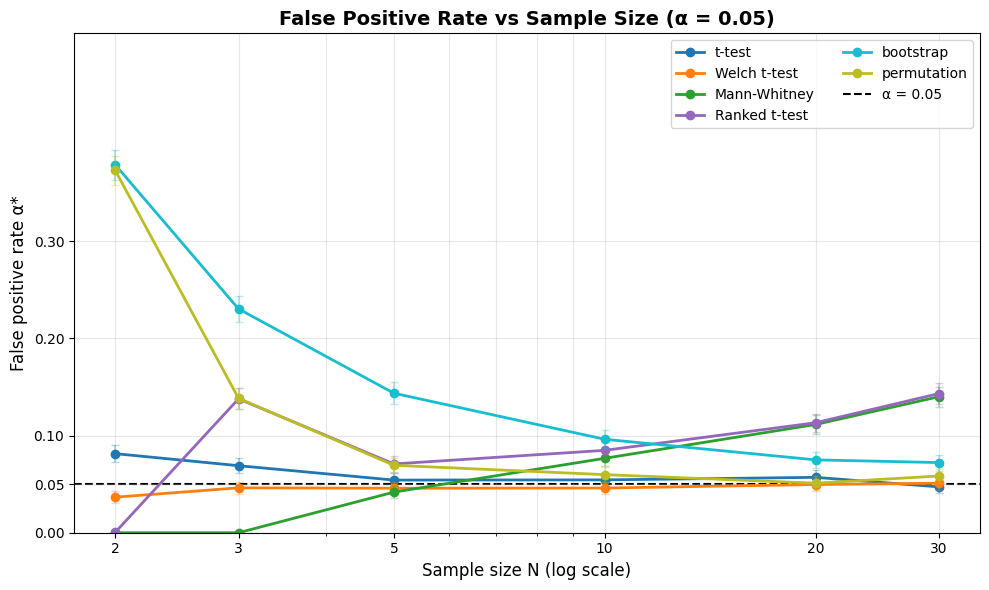


Plot created for α = 0.05


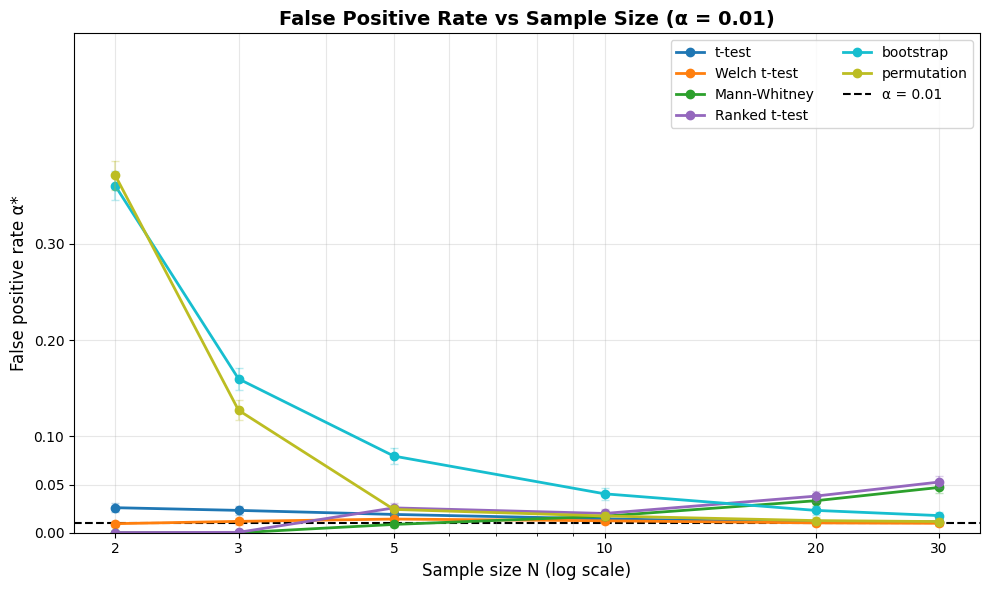


Plot created for α = 0.01


In [8]:
# Use configuration variables if available, otherwise use defaults
try:
    seed_grid = SEED_GRID
    alphas = ALPHAS
    n_resamples = N_RESAMPLES
except NameError:
    print("Warning: Configuration variables not defined. Using defaults.")
    print("Make sure to run Cell 3 (configuration) first.")
    # Use wider range matching paper (for better plots)
    seed_grid = [2, 3, 5, 10, 20, 30, 50, 100]
    alphas = [0.05, 0.01]
    n_resamples = 1000

print(f"Using empirical data from final_returns")
print(f"Testing across {len(seed_grid)} seed budgets: {seed_grid}")
print(f"Alpha levels: {alphas}")
print(f"Resamples per estimate: {n_resamples}")

fpr_empirical_results = []

# Get empirical samples from actual data
print("\n" + "="*60)
print("Estimating FPR using empirical procedure")
print("="*60)

for task in TASKS:
    task_df = final_returns[final_returns['task'] == task]
    available_algos = [a for a in ALGORITHMS if a in task_df['algorithm'].unique()]
    
    if len(available_algos) < 2:
        continue
    
    print(f"\nTask: {task}")
    
    # Use first two available algorithms as example pair
    algo1, algo2 = available_algos[0], available_algos[1]
    empirical1 = task_df[task_df['algorithm'] == algo1]['final_return_mean'].values
    empirical2 = task_df[task_df['algorithm'] == algo2]['final_return_mean'].values
    
    if len(empirical1) < 5 or len(empirical2) < 5:
        print(f"  Skipping {algo1} vs {algo2}: insufficient samples")
        continue
    
    print(f"  Using empirical samples: {algo1} (n={len(empirical1)}), {algo2} (n={len(empirical2)})")
    
    for alpha in alphas:
        print(f"    Alpha = {alpha}")
        for target_n in seed_grid:
            if target_n > min(len(empirical1), len(empirical2)):
                continue
            
            print(f"      Target seed budget N = {target_n}")
            for test_name in tests_list:
                try:
                    fpr, se = estimate_fpr_empirical(
                        empirical1, empirical2, 
                        test_name, target_n, 
                        alpha=alpha, 
                        n_resamples=n_resamples,  # Use full Nr = 10^3 as per paper
                        seed=None
                    )
                    fpr_empirical_results.append({
                        'task': task,
                        'algo1': algo1,
                        'algo2': algo2,
                        'test': test_name,
                        'alpha': alpha,
                        'target_n': target_n,
                        'fpr': fpr,
                        'se': se,
                        'expected_fpr': alpha
                    })
                    print(f"        {test_name:20s}: α* = {fpr:.4f} ± {se:.4f} (expected ≈ {alpha:.4f})")
                except Exception as e:
                    print(f"        {test_name:20s}: Error - {e}")

fpr_empirical_df = pd.DataFrame(fpr_empirical_results)

print("\n" + "="*60)
print("Empirical FPR Results Summary")
print("="*60)
print("Following paper: α* estimated as proportion of H0 rejections over Nr = 10^3 resamples")
print("Standard error: se(α*) = sqrt(α*(1-α*)/Nr)")
print("="*60)

if len(fpr_empirical_df) > 0:
    # Summary table by test and alpha (with standard errors)
    summary = fpr_empirical_df.groupby(['test', 'alpha']).agg({
        'fpr': ['mean', 'std', 'count'],
        'se': 'mean'
    })
    print("\nSummary by test and alpha level:")
    print(summary.round(4))
    
    # Average FPR across all tasks with standard errors
    print(f"\nAverage FPR by test (across all tasks and seed budgets):")
    avg_stats = fpr_empirical_df.groupby(['test', 'alpha']).agg({
        'fpr': 'mean',
        'se': 'mean'
    })
    for (test, alpha), row in avg_stats.iterrows():
        fpr_val = row['fpr']
        se_val = row['se']
        print(f"  {test:20s} (α={alpha:.3f}): α* = {fpr_val:.4f} ± {se_val:.4f} (expected ≈ {alpha:.4f})")
    
    display(fpr_empirical_df)
    
    # ============================================================================
    # Plot FPR vs Sample Size (matching paper Figure 4.2)
    # ============================================================================
    print("\n" + "="*60)
    print("Plotting FPR vs Sample Size")
    print("="*60)
    
    # Create plots for each alpha level
    for alpha in alphas:
        alpha_data = fpr_empirical_df[fpr_empirical_df['alpha'] == alpha]
        if len(alpha_data) == 0:
            continue
        
        # Aggregate across tasks and algorithm pairs (average FPR for each test and sample size)
        plot_data = alpha_data.groupby(['test', 'target_n']).agg({
            'fpr': 'mean',
            'se': 'mean'
        }).reset_index()
        
        if len(plot_data) == 0:
            continue
        
        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        # Color map for tests (matching paper style)
        test_colors = {
            't-test': '#1f77b4',           # blue
            'Welch t-test': '#ff7f0e',     # orange
            'Mann-Whitney': '#2ca02c',     # green
            'Ranked t-test': '#9467bd',    # purple
            'bootstrap': '#17becf',        # cyan
            'permutation': '#bcbd22'       # yellow-green
        }
        
        # Plot each test
        for test_name in tests_list:
            test_data = plot_data[plot_data['test'] == test_name].sort_values('target_n')
            if len(test_data) > 0:
                color = test_colors.get(test_name, '#000000')
                ax.plot(test_data['target_n'], test_data['fpr'], 
                       marker='o', label=test_name, linewidth=2, color=color, markersize=6)
                # Add error bars (standard errors)
                ax.errorbar(test_data['target_n'], test_data['fpr'], 
                           yerr=test_data['se'], 
                           fmt='none', color=color, alpha=0.3, capsize=3)
        
        # Add reference line at alpha
        ax.axhline(y=alpha, color='black', linestyle='--', linewidth=1.5, 
                  label=f'α = {alpha}', zorder=0)
        
        # Formatting
        ax.set_xlabel('Sample size N (log scale)', fontsize=12)
        ax.set_ylabel('False positive rate α*', fontsize=12)
        ax.set_title(f'False Positive Rate vs Sample Size (α = {alpha})', 
                    fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        
        # Set x-axis ticks to match available data and seed_grid
        available_n = sorted(plot_data['target_n'].unique())
        ax.set_xticks(available_n)
        ax.set_xticklabels([str(int(n)) for n in available_n])
        
        # Y-axis: show from 0 to at least 0.3, or higher if needed
        y_max = max(0.3, alpha_data['fpr'].max() * 1.15) if len(alpha_data) > 0 else 0.3
        ax.set_ylim([0, y_max])
        ax.set_yticks([0.0, 0.05, 0.1, 0.2, 0.3])
        
        ax.grid(True, alpha=0.3, which='both')
        ax.legend(loc='best', frameon=True, fontsize=10, ncol=2)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nPlot created for α = {alpha}")
else:
    print("No FPR results to display. Make sure final_returns is loaded in Cell 6.")

In [ ]:
# ============================================================================
# Generate Individual FPR Plots for Each Algorithm Pair and Task
# ============================================================================
# This cell creates separate plots for each (task, algorithm pair, alpha) combination
# Run this AFTER running the FPR analysis cell above
# ============================================================================

if 'fpr_empirical_df' in locals() and len(fpr_empirical_df) > 0:
    print("="*60)
    print("Generating individual FPR plots for each algorithm pair and task")
    print("="*60)
    
    # Create output directory for plots
    plot_dir = os.path.join(BASE, "fpr_plots")
    os.makedirs(plot_dir, exist_ok=True)
    
    # Get all unique combinations
    unique_combos = fpr_empirical_df.groupby(['task', 'algo1', 'algo2', 'alpha']).size().reset_index()
    print(f"\nFound {len(unique_combos)} unique (task, algo1, algo2, alpha) combinations")
    
    # Color map for tests (matching paper style)
    test_colors = {
        't-test': '#1f77b4',           # blue
        'Welch t-test': '#ff7f0e',     # orange
        'Mann-Whitney': '#2ca02c',     # green
        'Ranked t-test': '#9467bd',    # purple
        'bootstrap': '#17becf',        # cyan
        'permutation': '#bcbd22'       # yellow-green
    }
    
    plots_created = 0
    
    # Generate plot for each combination
    for idx, row in unique_combos.iterrows():
        task = row['task']
        algo1 = row['algo1']
        algo2 = row['algo2']
        alpha = row['alpha']
        
        # Filter data for this combination
        combo_data = fpr_empirical_df[
            (fpr_empirical_df['task'] == task) &
            (fpr_empirical_df['algo1'] == algo1) &
            (fpr_empirical_df['algo2'] == algo2) &
            (fpr_empirical_df['alpha'] == alpha)
        ]
        
        if len(combo_data) == 0:
            continue
        
        # Group by test and target_n
        plot_data = combo_data.groupby(['test', 'target_n']).agg({
            'fpr': 'mean',
            'se': 'mean'
        }).reset_index()
        
        if len(plot_data) == 0:
            continue
        
        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        # Plot each test
        for test_name in tests_list:
            test_data = plot_data[plot_data['test'] == test_name].sort_values('target_n')
            if len(test_data) > 0:
                color = test_colors.get(test_name, '#000000')
                ax.plot(test_data['target_n'], test_data['fpr'], 
                       marker='o', label=test_name, linewidth=2, color=color, markersize=6)
                # Add error bars (standard errors)
                ax.errorbar(test_data['target_n'], test_data['fpr'], 
                           yerr=test_data['se'], 
                           fmt='none', color=color, alpha=0.3, capsize=3)
        
        # Add reference line at alpha
        ax.axhline(y=alpha, color='black', linestyle='--', linewidth=1.5, 
                  label=f'α = {alpha}', zorder=0)
        
        # Formatting
        ax.set_xlabel('Sample size N (log scale)', fontsize=12)
        ax.set_ylabel('False positive rate α*', fontsize=12)
        ax.set_title(f'FPR vs Sample Size: {task}\n{algo1} vs {algo2} (α = {alpha})', 
                    fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        
        # Set x-axis ticks
        available_n = sorted(plot_data['target_n'].unique())
        ax.set_xticks(available_n)
        ax.set_xticklabels([str(int(n)) for n in available_n])
        
        # Y-axis: show from 0 to at least 0.3, or higher if needed
        y_max = max(0.3, combo_data['fpr'].max() * 1.15) if len(combo_data) > 0 else 0.3
        ax.set_ylim([0, y_max])
        ax.set_yticks([0.0, 0.05, 0.1, 0.2, 0.3])
        
        ax.grid(True, alpha=0.3, which='both')
        ax.legend(loc='best', frameon=True, fontsize=10, ncol=2)
        
        plt.tight_layout()
        
        # Save plot
        safe_task = task.replace('/', '_').replace('-', '_')
        safe_algo1 = algo1.replace('/', '_')
        safe_algo2 = algo2.replace('/', '_')
        filename = f"fpr_{safe_task}_{safe_algo1}_vs_{safe_algo2}_alpha{alpha:.2f}.png"
        filepath = os.path.join(plot_dir, filename)
        plt.savefig(filepath, bbox_inches='tight', dpi=150)
        plt.close()  # Close to free memory
        
        plots_created += 1
        
        # Show progress every 10 plots
        if plots_created % 10 == 0:
            print(f"Created {plots_created} plots...")
    
    print(f"\n{'='*60}")
    print(f"Created {plots_created} individual FPR plots")
    print(f"Plots saved to: {plot_dir}")
    print(f"{'='*60}")
    
else:
    print("No FPR results available. Run the FPR analysis cell above first.")

In [9]:
# ============================================================================
# Statistical Power Analysis - Empirical Procedure
# Following the rl_stats methodology from the Hitchhiker's Guide
# ============================================================================

def estimate_power_empirical(empirical_samples1, empirical_samples2,
                            test_name, target_n, effect_size_epsilon,
                            alpha=0.05, n_resamples=10000, seed=None):
    """
    Estimate Statistical Power using empirical procedure:
    "If there is a true difference between algorithms A and B, 
    how often does a statistical test correctly reject H0?"
    
    Procedure:
    1. Generate return distributions for A, B and recenter
    2. For synthetic ε, shift one full distribution: X_B^(ε) = X_B + ε · σ_pool
    3. Draw N samples from X_A and X_B^(ε)
    4. Apply test at level α
    5. Repeat for R resamples
    6. Power = (# rejections) / R
    
    Args:
        empirical_samples1, empirical_samples2: actual data samples from algorithms A and B
        test_name: name of test from tests_list
        target_n: target seed budget (sample size)
        effect_size_epsilon: effect size ε ∈ {0.5, 1, 2} (Cohen's d)
        alpha: significance level
        n_resamples: number of resamples R (default 10^4 as per paper)
        seed: random seed
    
    Returns:
        power: empirical statistical power (1 - β*)
        se: standard error
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Determine whether to use median or mean based on test
    use_median = (test_name == 'Mann-Whitney' or test_name == 'Ranked t-test')
    
    # Step 1: Recenter distributions (same as FPR)
    recentered1, recentered2 = recenter_samples(empirical_samples1, empirical_samples2, use_median)
    
    # Step 2: Compute pooled standard deviation for shifting
    if use_median:
        # For median-based tests, use median absolute deviation (MAD) scaled
        mad1 = np.median(np.abs(recentered1 - np.median(recentered1)))
        mad2 = np.median(np.abs(recentered2 - np.median(recentered2)))
        sigma_pool = np.sqrt((mad1**2 + mad2**2) / 2) * 1.4826  # Scale MAD to approximate SD
    else:
        # For mean-based tests, use pooled standard deviation
        std1 = np.std(recentered1, ddof=1)
        std2 = np.std(recentered2, ddof=1)
        n1, n2 = len(recentered1), len(recentered2)
        sigma_pool = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1 + n2 - 2))
    
    # Shift distribution 2 by ε · σ_pool: X_B^(ε) = X_B + ε · σ_pool
    shifted2 = recentered2 + effect_size_epsilon * sigma_pool
    
    # Step 3: Sample and test
    true_positives = 0
    
    for _ in range(n_resamples):
        # Draw N samples (with replacement) from X_A and X_B^(ε)
        sample1 = np.random.choice(recentered1, size=target_n, replace=True)
        sample2 = np.random.choice(shifted2, size=target_n, replace=True)
        
        # Apply test at level α
        try:
            reject = run_test(test_name, sample1, sample2, alpha=alpha)
            if reject:
                true_positives += 1
        except:
            continue
    
    # Step 4: Empirical power = (# rejections) / R
    power = true_positives / n_resamples
    
    # Standard error
    se = np.sqrt(power * (1 - power) / n_resamples) if n_resamples > 0 else 0
    
    return power, se


In [ ]:
# Use configuration variables if available
try:
    seed_grid = SEED_GRID
    alphas = ALPHAS
    epsilons = EPSILONS
    n_resamples_power = N_RESAMPLES * 10  # Use 10^4 for power as per paper
except NameError:
    print("Warning: Configuration variables not defined. Using defaults.")
    print("Make sure to run Cell 3 (configuration) first.")
    seed_grid = [2, 3, 5, 10, 20, 30, 50, 100]
    alphas = [0.05, 0.01]
    epsilons = [0.5, 1.0, 2.0]
    n_resamples_power = 10000

print(f"Using empirical data from final_returns")
print(f"Testing across {len(seed_grid)} seed budgets: {seed_grid}")
print(f"Effect sizes (ε): {epsilons}")
print(f"Alpha levels: {alphas}")
print(f"Resamples per estimate: {n_resamples_power}")

power_empirical_results = []

# Get empirical samples from actual data
print("\n" + "="*60)
print("Estimating Statistical Power using empirical procedure")
print("="*60)

for task in TASKS:
    task_df = final_returns[final_returns['task'] == task]
    available_algos = [a for a in ALGORITHMS if a in task_df['algorithm'].unique()]
    
    if len(available_algos) < 2:
        continue
    
    print(f"\nTask: {task}")
    
    # Use first two available algorithms as example pair
    algo1, algo2 = available_algos[0], available_algos[1]
    empirical1 = task_df[task_df['algorithm'] == algo1]['final_return_mean'].values
    empirical2 = task_df[task_df['algorithm'] == algo2]['final_return_mean'].values
    
    if len(empirical1) < 5 or len(empirical2) < 5:
        print(f"  Skipping {algo1} vs {algo2}: insufficient samples")
        continue
    
    print(f"  Using empirical samples: {algo1} (n={len(empirical1)}), {algo2} (n={len(empirical2)})")
    
    for alpha in alphas:
        print(f"    Alpha = {alpha}")
        for epsilon in epsilons:
            print(f"      Effect size ε = {epsilon}")
            for target_n in seed_grid:
                if target_n > min(len(empirical1), len(empirical2)):
                    continue
                
                print(f"        Target seed budget N = {target_n}")
                for test_name in tests_list:
                    try:
                        power, se = estimate_power_empirical(
                            empirical1, empirical2,
                            test_name, target_n,
                            effect_size_epsilon=epsilon,
                            alpha=alpha,
                            n_resamples=min(n_resamples_power, 1000),  # Limit for faster execution
                            seed=None
                        )
                        power_empirical_results.append({
                            'task': task,
                            'algo1': algo1,
                            'algo2': algo2,
                            'test': test_name,
                            'alpha': alpha,
                            'epsilon': epsilon,
                            'target_n': target_n,
                            'power': power,
                            'se': se
                        })
                        print(f"          {test_name:20s}: Power = {power:.4f} ± {se:.4f}")
                    except Exception as e:
                        print(f"          {test_name:20s}: Error - {e}")

power_empirical_df = pd.DataFrame(power_empirical_results)

print("\n" + "="*60)
print("Empirical Power Results Summary")
print("="*60)
print("Following paper: Power estimated as proportion of H0 rejections over R resamples")
print("="*60)

if len(power_empirical_df) > 0:
    # Summary tables
    print("\nAverage Power by test, effect size, and sample size:")
    summary = power_empirical_df.groupby(['test', 'epsilon', 'target_n', 'alpha'])['power'].mean().unstack(['epsilon', 'alpha'])
    print(summary.round(4))
    
    # Average power across all tasks
    print(f"\nAverage Power by test and effect size (across all tasks and seed budgets):")
    avg_power = power_empirical_df.groupby(['test', 'epsilon', 'alpha']).agg({
        'power': 'mean',
        'se': 'mean'
    })
    for (test, epsilon, alpha), row in avg_power.iterrows():
        power_val = row['power']
        se_val = row['se']
        print(f"  {test:20s} (ε={epsilon:.1f}, α={alpha:.3f}): Power = {power_val:.4f} ± {se_val:.4f}")
    
    display(power_empirical_df)
else:
    print("No power results to display. Make sure final_returns is loaded in Cell 6.")

Using empirical data from final_returns
Testing across 6 seed budgets: [2, 3, 5, 10, 20, 30]
Effect sizes (ε): [0.5, 1.0, 2.0]
Alpha levels: [0.05, 0.01]
Resamples per estimate: 10000

Estimating Statistical Power using empirical procedure

Task: Hopper-v5
  Using empirical samples: SAC (n=58), TD3 (n=62)
    Alpha = 0.05
      Effect size ε = 0.5
        Target seed budget N = 2
          t-test              : Power = 0.1820 ± 0.0122
          Welch t-test        : Power = 0.0940 ± 0.0092
          Mann-Whitney        : Power = 0.0000 ± 0.0000
          Ranked t-test       : Power = 0.0000 ± 0.0000
          bootstrap           : Power = 0.6450 ± 0.0151
          permutation         : Power = 0.6830 ± 0.0147
        Target seed budget N = 3
          t-test              : Power = 0.2260 ± 0.0132
          Welch t-test        : Power = 0.1590 ± 0.0116
          Mann-Whitney        : Power = 0.0000 ± 0.0000
          Ranked t-test       : Power = 0.1530 ± 0.0114
          bootstrap     

In [ ]:
# ============================================================================
# Compute Empirical Effect Sizes from Actual Data
# Compare synthetic effect sizes (ε) with true empirical effect sizes
# ============================================================================

print("="*60)
print("Empirical Effect Sizes from Actual Data")
print("="*60)
print("Computing ε = |Δμ| / σ_pool for each algorithm pair")
print("This shows the true effect sizes in your experiments")
print()

empirical_effect_sizes = []

for task in TASKS:
    task_df = final_returns[final_returns['task'] == task]
    available_algos = [a for a in ALGORITHMS if a in task_df['algorithm'].unique()]
    
    if len(available_algos) < 2:
        continue
    
    print(f"\n{task}:")
    
    # Compute effect size for all algorithm pairs
    for i, algo1 in enumerate(available_algos):
        for algo2 in available_algos[i+1:]:
            sample1 = task_df[task_df['algorithm'] == algo1]['final_return_mean'].values
            sample2 = task_df[task_df['algorithm'] == algo2]['final_return_mean'].values
            
            if len(sample1) < 2 or len(sample2) < 2:
                continue
            
            # Compute pooled standard deviation
            mean1, mean2 = np.mean(sample1), np.mean(sample2)
            std1, std2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)
            n1, n2 = len(sample1), len(sample2)
            sigma_pool = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1 + n2 - 2))
            
            # Empirical effect size: ε = |Δμ| / σ_pool
            delta_mu = abs(mean1 - mean2)
            epsilon_empirical = delta_mu / sigma_pool if sigma_pool > 0 else 0
            
            empirical_effect_sizes.append({
                'task': task,
                'algo1': algo1,
                'algo2': algo2,
                'mean1': mean1,
                'mean2': mean2,
                'delta_mu': delta_mu,
                'sigma_pool': sigma_pool,
                'epsilon_empirical': epsilon_empirical,
                'n1': n1,
                'n2': n2
            })
            
            print(f"  {algo1} vs {algo2}: ε = {epsilon_empirical:.3f} (Δμ = {delta_mu:.2f}, σ_pool = {sigma_pool:.2f})")

empirical_effects_df = pd.DataFrame(empirical_effect_sizes)

if len(empirical_effects_df) > 0:
    print("\n" + "="*60)
    print("Summary of Empirical Effect Sizes")
    print("="*60)
    print(f"Mean empirical effect size: {empirical_effects_df['epsilon_empirical'].mean():.3f}")
    print(f"Median empirical effect size: {empirical_effects_df['epsilon_empirical'].median():.3f}")
    print(f"Min: {empirical_effects_df['epsilon_empirical'].min():.3f}, Max: {empirical_effects_df['epsilon_empirical'].max():.3f}")
    print("\nEffect sizes by task:")
    for task in TASKS:
        task_effects = empirical_effects_df[empirical_effects_df['task'] == task]
        if len(task_effects) > 0:
            print(f"  {task}: mean ε = {task_effects['epsilon_empirical'].mean():.3f}")
    
    display(empirical_effects_df)
else:
    print("No effect sizes computed. Make sure final_returns is loaded.")

In [ ]:
# ============================================================================
# Statistical Analysis using rl_stats methodology
# Following: https://github.com/flowersteam/rl_stats
# ============================================================================

# Configuration for statistical tests (matching rl_stats example)
test_id = "Welch t-test"  # Recommended by Hitchhiker's Guide
confidence_level = 0.01   # alpha
id_central = 'median'     # 'mean' or 'median'
id_error = 80             # percentile for error bands (also: 'std', 'sem')

print(f"Statistical test configuration:")
print(f"  Test: {test_id}")
print(f"  Confidence level (α): {confidence_level}")
print(f"  Central tendency: {id_central}")
print(f"  Error bands: {id_error}th percentile")
print(f"\nAvailable tests: {tests_list}")

# Show data summary by task and algorithm
print(f"\n{'='*60}")
print("Learning Curves Summary")
print(f"{'='*60}")
for task in TASKS:
    task_df = curves[curves['task'] == task]
    if not task_df.empty:
        print(f"\n{task}:")
        for algo in ALGORITHMS:
            algo_df = task_df[task_df['algorithm'] == algo]
            if not algo_df.empty:
                n_seeds = algo_df['seed'].nunique()
                n_steps = algo_df['env_steps'].nunique()
                print(f"  {algo}: {n_seeds} seeds, {n_steps} evaluation points")

Statistical test configuration:
  Test: Welch t-test
  Confidence level (α): 0.01
  Central tendency: median
  Error bands: 80th percentile

Available tests: ['t-test', 'Welch t-test', 'Mann-Whitney', 'Ranked t-test', 'bootstrap', 'permutation']

Learning Curves Summary

Hopper-v5:
  SAC: 137 seeds, 100 evaluation points
  TD3: 127 seeds, 100 evaluation points
  DDPG: 117 seeds, 100 evaluation points
  PPO: 143 seeds, 100 evaluation points

Walker2d-v5:
  SAC: 107 seeds, 100 evaluation points
  TD3: 134 seeds, 100 evaluation points
  DDPG: 123 seeds, 100 evaluation points
  PPO: 130 seeds, 100 evaluation points

HalfCheetah-v5:
  SAC: 74 seeds, 100 evaluation points
  TD3: 85 seeds, 100 evaluation points
  DDPG: 78 seeds, 100 evaluation points
  PPO: 119 seeds, 100 evaluation points

Ant-v5:
  SAC: 73 seeds, 100 evaluation points
  TD3: 82 seeds, 100 evaluation points
  DDPG: 83 seeds, 100 evaluation points
  PPO: 122 seeds, 100 evaluation points

Humanoid-v5:
  SAC: 68 seeds, 100 eval


Hopper-v5: TD3 (127 seeds) vs DDPG (117 seeds)
  Steps: 100 x 100 evaluation points


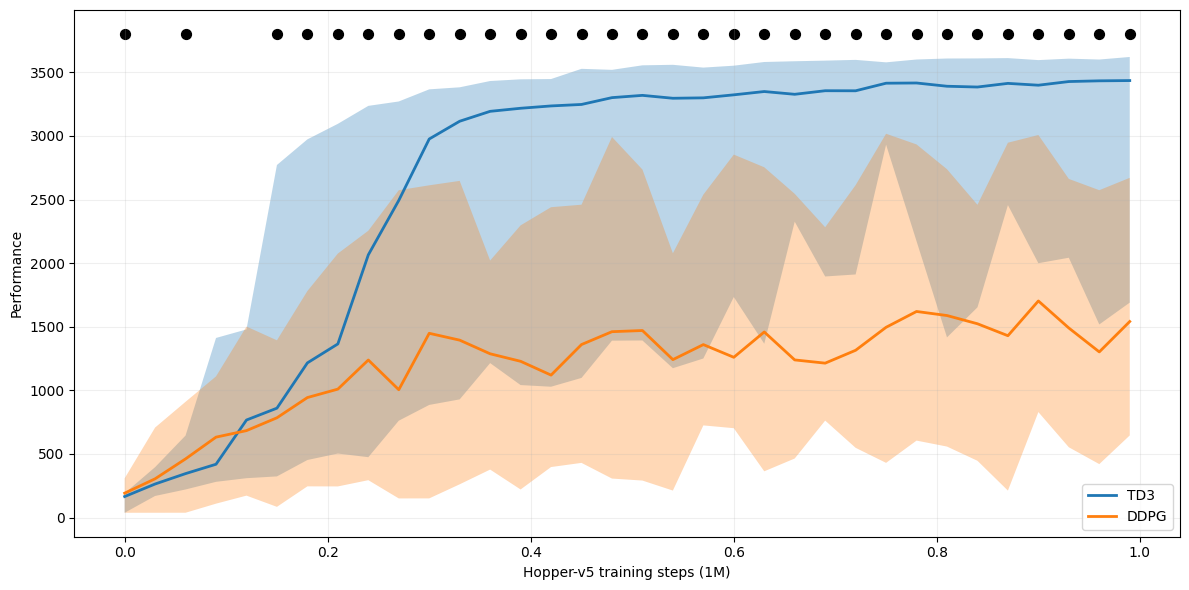


Hopper-v5: TD3 (127 seeds) vs PPO (143 seeds)
  Steps: 100 x 100 evaluation points


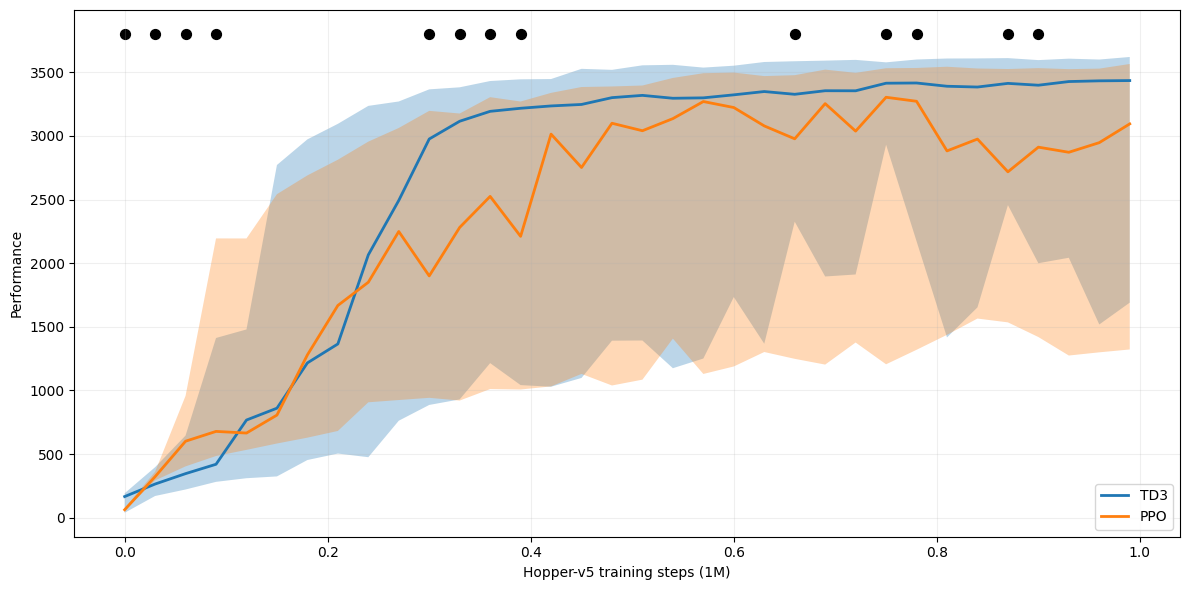


Hopper-v5: DDPG (117 seeds) vs PPO (143 seeds)
  Steps: 100 x 100 evaluation points


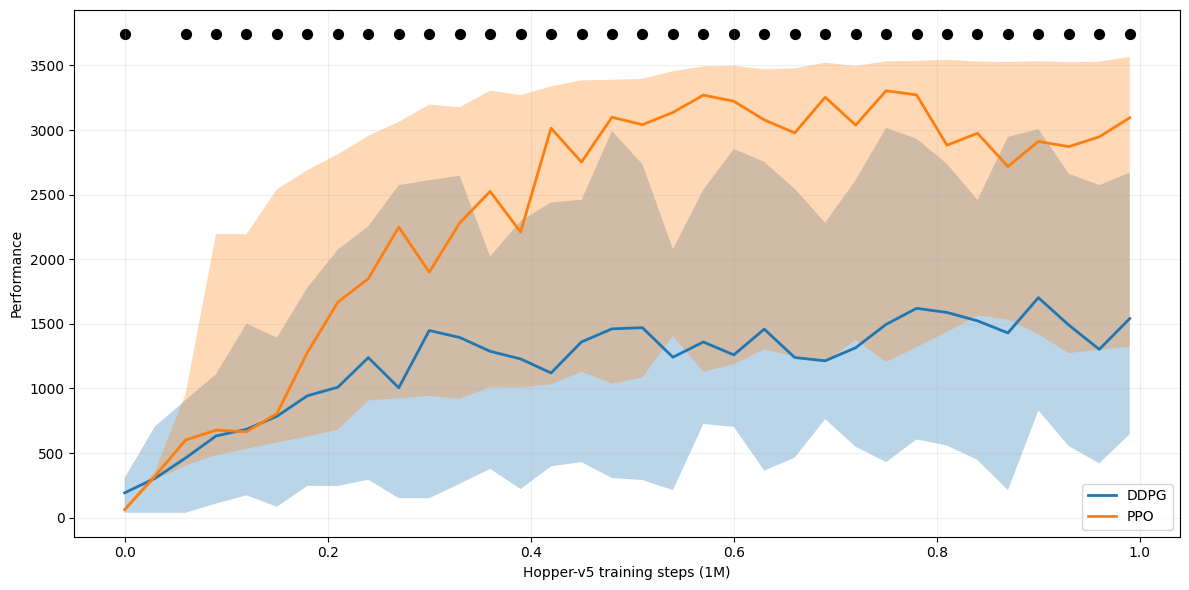


Task: Walker2d-v5


In [ ]:
# ============================================================================
# Pairwise Algorithm Comparisons with Significance Markers
# This replicates the rl_stats example_test_and_plot.py workflow
# ============================================================================

# Compare all algorithm pairs for each task
for task in TASKS:
    print(f"\n{'='*60}")
    print(f"Task: {task}")
    print(f"{'='*60}")
    
    # Get all algorithm pairs
    task_curves = curves[curves['task'] == task]
    available_algos = [a for a in ALGORITHMS if a in task_curves['algorithm'].unique()]
    
    if len(available_algos) < 2:
        print(f"  Not enough algorithms with data for {task}")
        continue
    
    # Generate all pairs
    for i, algo1 in enumerate(available_algos):
        for algo2 in available_algos[i+1:]:
            plot_task_comparison(
                curves, task, algo1, algo2,
                test_id=test_id,
                confidence_level=confidence_level,
                id_central=id_central,
                id_error=id_error,
                steps_scale=1e6,
                downsampling_fact=3
            )

In [24]:
# ============================================================================
# Final Return Statistical Comparisons
# Run all tests on final evaluation returns (like rl_stats run_tests.py)
# ============================================================================

# final_returns is already loaded in Cell 6
print(f"Using {len(final_returns)} final evaluation returns")
print(f"Unique (task, algo): {final_returns.groupby(['task', 'algorithm']).size().shape[0]} combinations")

# Run all statistical tests on final returns for each task/algorithm pair
results = []

for task in TASKS:
    task_df = final_returns[final_returns['task'] == task]
    available_algos = [a for a in ALGORITHMS if a in task_df['algorithm'].unique()]
    
    for i, algo1 in enumerate(available_algos):
        for algo2 in available_algos[i+1:]:
            sample1 = task_df[task_df['algorithm'] == algo1]['final_return_mean'].values
            sample2 = task_df[task_df['algorithm'] == algo2]['final_return_mean'].values
            
            if len(sample1) < 2 or len(sample2) < 2:
                continue
            
            # Run all tests from rl_stats
            for test_name in tests_list:
                try:
                    reject = run_test(test_name, sample1, sample2, alpha=confidence_level)
                    results.append({
                        'task': task,
                        'algo1': algo1,
                        'algo2': algo2,
                        'n1': len(sample1),
                        'n2': len(sample2),
                        'mean1': np.mean(sample1),
                        'mean2': np.mean(sample2),
                        'test': test_name,
                        'alpha': confidence_level,
                        'reject_H0': reject,
                        'winner': algo1 if np.mean(sample1) > np.mean(sample2) else algo2
                    })
                except Exception as e:
                    print(f"  Warning: {test_name} failed for {task} {algo1} vs {algo2}: {e}")

results_df = pd.DataFrame(results)
print(f"\nRan {len(results_df)} statistical tests")
display(results_df.head(20))

Using 964 final evaluation returns
Unique (task, algo): 20 combinations

Ran 180 statistical tests


,task,algo1,algo2,n1,n2,mean1,mean2,test,alpha,reject_H0,winner
0,Hopper-v5,SAC,TD3,50,53,2914.607232,3052.385836,t-test,0.01,False,TD3
1,Hopper-v5,SAC,TD3,50,53,2914.607232,3052.385836,Welch t-test,0.01,False,TD3
2,Hopper-v5,SAC,TD3,50,53,2914.607232,3052.385836,Mann-Whitney,0.01,True,TD3
3,Hopper-v5,SAC,TD3,50,53,2914.607232,3052.385836,Ranked t-test,0.01,True,TD3
4,Hopper-v5,SAC,TD3,50,53,2914.607232,3052.385836,bootstrap,0.01,False,TD3
5,Hopper-v5,SAC,TD3,50,53,2914.607232,3052.385836,permutation,0.01,False,TD3
6,Hopper-v5,SAC,DDPG,50,51,2914.607232,1636.883225,t-test,0.01,True,SAC
7,Hopper-v5,SAC,DDPG,50,51,2914.607232,1636.883225,Welch t-test,0.01,True,SAC
8,Hopper-v5,SAC,DDPG,50,51,2914.607232,1636.883225,Mann-Whitney,0.01,True,SAC
9,Hopper-v5,SAC,DDPG,50,51,2914.607232,1636.883225,Ranked t-test,0.01,True,SAC


In [25]:
# ============================================================================
# Summary Tables (like rl_stats Hitchhiker's Guide Tables)
# ============================================================================

if len(results_df) > 0:
    # Summary by test: how often does each test reject H0?
    print("="*60)
    print("Test Rejection Rates (H0: no difference between algorithms)")
    print("="*60)
    test_summary = results_df.groupby('test')['reject_H0'].agg(['sum', 'count', 'mean'])
    test_summary.columns = ['Rejections', 'Total', 'Rejection Rate']
    test_summary = test_summary.sort_values('Rejection Rate', ascending=False)
    display(test_summary)
    
    # Significant results by task
    print("\n" + "="*60)
    print("Significant Differences by Task (α = {})".format(confidence_level))
    print("="*60)
    
    for task in TASKS:
        task_results = results_df[results_df['task'] == task]
        if task_results.empty:
            continue
            
        print(f"\n{task}:")
        
        # For each algorithm pair
        pairs = task_results.groupby(['algo1', 'algo2'])
        for (algo1, algo2), pair_df in pairs:
            # Count how many tests agree
            n_reject = pair_df['reject_H0'].sum()
            n_tests = len(pair_df)
            
            if n_reject > 0:
                winner = pair_df[pair_df['reject_H0']]['winner'].mode()
                winner = winner.iloc[0] if len(winner) > 0 else '?'
                agreeing_tests = pair_df[pair_df['reject_H0']]['test'].tolist()
                print(f"  {algo1} vs {algo2}: {n_reject}/{n_tests} tests reject H0")
                print(f"    Winner: {winner}")
                print(f"    Agreeing tests: {agreeing_tests}")
    
    # Pivot table: which algorithms are significantly better?
    print("\n" + "="*60)
    print("Pairwise Comparison Matrix (Welch t-test)")
    print("="*60)
    
    welch_results = results_df[results_df['test'] == 'Welch t-test']
    if not welch_results.empty:
        for task in TASKS:
            task_results = welch_results[welch_results['task'] == task]
            if task_results.empty:
                continue
            
            print(f"\n{task}:")
            algos = sorted(set(task_results['algo1'].unique()) | set(task_results['algo2'].unique()))
            
            # Build matrix
            matrix = pd.DataFrame(index=algos, columns=algos, data='-')
            for _, row in task_results.iterrows():
                if row['reject_H0']:
                    if row['mean1'] > row['mean2']:
                        matrix.loc[row['algo1'], row['algo2']] = '>'
                        matrix.loc[row['algo2'], row['algo1']] = '<'
                    else:
                        matrix.loc[row['algo1'], row['algo2']] = '<'
                        matrix.loc[row['algo2'], row['algo1']] = '>'
                else:
                    matrix.loc[row['algo1'], row['algo2']] = '='
                    matrix.loc[row['algo2'], row['algo1']] = '='
            
            display(matrix)
else:
    print("No results to summarize")

Test Rejection Rates (H0: no difference between algorithms)


,Rejections,Total,Rejection Rate
test,,,
Mann-Whitney,25,30,0.833333
Ranked t-test,25,30,0.833333
Welch t-test,22,30,0.733333
bootstrap,22,30,0.733333
t-test,22,30,0.733333
permutation,21,30,0.700000



Significant Differences by Task (α = 0.01)

Hopper-v5:
  DDPG vs PPO: 6/6 tests reject H0
    Winner: PPO
    Agreeing tests: ['t-test', 'Welch t-test', 'Mann-Whitney', 'Ranked t-test', 'bootstrap', 'permutation']
  SAC vs DDPG: 6/6 tests reject H0
    Winner: SAC
    Agreeing tests: ['t-test', 'Welch t-test', 'Mann-Whitney', 'Ranked t-test', 'bootstrap', 'permutation']
  SAC vs TD3: 2/6 tests reject H0
    Winner: TD3
    Agreeing tests: ['Mann-Whitney', 'Ranked t-test']
  TD3 vs DDPG: 6/6 tests reject H0
    Winner: TD3
    Agreeing tests: ['t-test', 'Welch t-test', 'Mann-Whitney', 'Ranked t-test', 'bootstrap', 'permutation']
  TD3 vs PPO: 2/6 tests reject H0
    Winner: TD3
    Agreeing tests: ['Mann-Whitney', 'Ranked t-test']

Walker2d-v5:
  SAC vs DDPG: 6/6 tests reject H0
    Winner: SAC
    Agreeing tests: ['t-test', 'Welch t-test', 'Mann-Whitney', 'Ranked t-test', 'bootstrap', 'permutation']
  SAC vs PPO: 6/6 tests reject H0
    Winner: SAC
    Agreeing tests: ['t-test', 'Welc

,DDPG,PPO,SAC,TD3
DDPG,-,<,<,<
PPO,>,-,=,=
SAC,>,=,-,=
TD3,>,=,=,-



Walker2d-v5:


,DDPG,PPO,SAC,TD3
DDPG,-,=,<,<
PPO,=,-,<,<
SAC,>,>,-,=
TD3,>,>,=,-



HalfCheetah-v5:


,DDPG,PPO,SAC,TD3
DDPG,-,>,<,=
PPO,<,-,<,<
SAC,>,>,-,=
TD3,=,>,=,-



Ant-v5:


,DDPG,PPO,SAC,TD3
DDPG,-,<,<,<
PPO,>,-,<,<
SAC,>,>,-,>
TD3,>,>,<,-



Humanoid-v5:


,DDPG,PPO,SAC,TD3
DDPG,-,<,<,=
PPO,>,-,<,>
SAC,>,>,-,>
TD3,=,<,<,-
